In [90]:
# !pip install -U sentence-transformers

# Numerical and Data Manipulation
import numpy as np
import pandas as pd
# Files
import joblib
import json
# Tools
from google.colab import drive
from IPython.display import clear_output
from tqdm import tqdm
# Machine Learning Models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sentence_transformers import SentenceTransformer
# Plotting Libraries
import matplotlib.pyplot as plt
import seaborn as sns
# Scikit-learn Metrics and Preprocessing
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc
)
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, StratifiedKFold
# XGBoost Plotting Function
from xgboost import plot_importance


clear_output()
# drive.mount('/content/drive')

ads_choice = ['real-vs-fs', 'real-vs-zs', 'real-vs-gen']
ads = ads_choice[2]

hypertune = False

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Ads and Embeddings

**Real Ads**

In [91]:
# Load data
# data = pd.read_csv('IT22_withEmbeddings.csv')
main_pages_data = pd.read_csv('data/real_ads_embeddings.csv')

# Convert 'bert_embeddings' column back to lists of floats
main_pages_data['bert_embeddings'] = main_pages_data['bert_embeddings'].apply(lambda x: np.array(list(map(float, x.split(',')))))

# Get ordered embeddings by party
main_parties = sorted(main_pages_data['party'].unique())

main_parties_labels = ["3POLO", "AVD", "FDI", "FI", "LEGA", "M5S", "PD", "Complete\nDataset"]

embeddings_list = []
labels_list = []
text_list = []

for i, party in enumerate(main_parties):
    party_data = main_pages_data[main_pages_data['party'] == party]
    embeddings = np.vstack(party_data['bert_embeddings'].to_numpy())
    texts = party_data['ad_creative_bodies'].tolist()

    embeddings_list.append(embeddings)
    labels_list.append(np.full(len(party_data), i))
    text_list.extend(texts)

ra_ordered_embeddings = np.vstack(embeddings_list)
ra_party_labels = np.concatenate(labels_list)
ra_ordered_text = text_list

print(len(ra_ordered_embeddings), len(ra_party_labels), len(ra_ordered_text))


635 635 635


**[3.1] Few Shots**

In [92]:
# Load the CSV file
fs_gen_text_embeddings_df = pd.read_csv('mp_gen_text_party_2_embeddings.csv')

ads_per_party = 100

# Convert the 'gen_text_embeddings' column back to lists of NumPy arrays
fs_gen_text_embeddings_df['gen_text_embeddings'] = fs_gen_text_embeddings_df['gen_text_embeddings'].apply(
    lambda x: [np.array(list(map(float, embedding.split(',')))) for embedding in x.split('|')]
)

# Add the 'party' column from the main_parties list
fs_gen_text_embeddings_df['party'] = main_parties

# Reorder columns to place 'party' first
fs_gen_text_embeddings_df = fs_gen_text_embeddings_df[['party', 'gen_text_embeddings']]

# # Get ordered embeddings by party
fs_ordered_embeddings = np.vstack([np.vstack(fs_gen_text_embeddings_df[fs_gen_text_embeddings_df['party'] == party]['gen_text_embeddings'].to_numpy())
                                   for party in main_parties])

# Generate labels for each party
fs_party_labels = np.concatenate([np.full(ads_per_party, i)
                               for i, party in enumerate(main_parties)])

# Import the CSV file
fs_gen_text_df = pd.read_csv('mp_generated_ads_party_2.csv')
# Convert the 'top_ads' column to lists of strings
fs_gen_text_df['gen_plain_list'] = fs_gen_text_df['gen_plain_list'].apply(eval)

fs_ordered_text = [text for sublist in fs_gen_text_df['gen_plain_list'] for text in sublist]

print(len(fs_ordered_embeddings), len(fs_party_labels), len(fs_ordered_text))


700 700 700


**[4] Zero Shot**

In [93]:
# Load the CSV file
zs_gen_text_embeddings_df = pd.read_csv('zero_shot_gen_embeddings.csv')

ads_per_party = 111

# Convert the 'gen_text_embeddings' column back to lists of NumPy arrays
zs_gen_text_embeddings_df['gen_text_embeddings'] = zs_gen_text_embeddings_df['gen_text_embeddings'].apply(
    lambda x: [np.array(list(map(float, embedding.split(',')))) for embedding in x.split('|')]
)

# Add the 'party' column from the main_parties list
zs_gen_text_embeddings_df['party'] = main_parties

# Reorder columns to place 'party' first
zs_gen_text_embeddings_df = zs_gen_text_embeddings_df[['party', 'gen_text_embeddings']]

# # Get ordered embeddings by party
zs_ordered_embeddings = np.vstack([np.vstack(zs_gen_text_embeddings_df[zs_gen_text_embeddings_df['party'] == party]['gen_text_embeddings'].to_numpy())
                                   for party in main_parties])

# Generate labels for each party
zs_party_labels = np.concatenate([np.full(ads_per_party, i)
                               for i, party in enumerate(main_parties)])

# Import the CSV file
zero_shot_gen_text_df = pd.read_csv('zero_shot_generated_ads.csv')
# Convert the 'top_ads' column to lists of strings
zero_shot_gen_text_df['gen_plain_list'] = zero_shot_gen_text_df['gen_plain_list'].apply(eval)

zs_ordered_text = [text for sublist in zero_shot_gen_text_df['gen_plain_list'] for text in sublist]

print(len(zs_ordered_embeddings), len(zs_party_labels), len(zs_ordered_text))


777 777 777


**Real Ads Vs Few Shots**

Human Valutation Excel Creation

In [94]:
# np.random.seed(52696)  # Ensuring reproducibility

# # Randomly select 25 texts from each real and generated ads
# selected_real_indices = np.random.choice(range(len(ra_ordered_text)), 25, replace=False)
# selected_generated_indices = np.random.choice(range(len(fs_ordered_text)), 25, replace=False)

# # Extract data for the real ads
# real_texts = [ra_ordered_text[idx] for idx in selected_real_indices]
# real_party_labels = [main_parties[ra_party_labels[idx]] for idx in selected_real_indices]
# real_booleans = [0] * 25  # Boolean set to 0 for real ads

# # Extract data for the generated ads
# generated_texts = [fs_ordered_text[idx] for idx in selected_generated_indices]
# generated_party_labels = [main_parties[fs_party_labels[idx]] for idx in selected_generated_indices]
# generated_booleans = [1] * 25  # Boolean set to 1 for generated ads

# display(pd.Series(real_party_labels).value_counts())
# display(pd.Series(generated_party_labels).value_counts())

# # Combine real and generated ads into a single DataFrame
# df = pd.DataFrame({
#     "Ad Text": real_texts + generated_texts,
#     "Party": real_party_labels + generated_party_labels,
#     "Generated (1) / Real (0)": real_booleans + generated_booleans
# })

# # Save to Excel file
# output_path = "LLM_HumanClassification.xlsx"
# df.to_excel(output_path, index=False)

# np.random.seed(42)  # Ensuring reproducibility

In [95]:
# Initialize lists to collect data
vs_rafs_embeddings = []
vs_rafs_class_labels = []  # 0 for real, 1 for generated
vs_rafs_party_labels = []  # Party index
vs_rafs_texts = []

# Ensure reproducibility
np.random.seed(42)

# Iterate over each party
for i, party in enumerate(main_parties):
    # Real ads for the party
    party_real_indices = np.where(ra_party_labels == i)[0]
    num_real_ads = len(party_real_indices)

    # Generated ads for the party
    party_generated_indices = np.where(fs_party_labels == i)[0]
    num_generated_ads = len(party_generated_indices)

    # Determine the minimum number of ads between real and generated
    num_ads_to_use = min(num_real_ads, num_generated_ads)

    # print(party, num_real_ads, num_gen_ads, num_ads_to_use)
    print(f"{party}: Ads:{num_ads_to_use} - R:{num_real_ads}, G:{num_generated_ads}")

    # Randomly select ads
    selected_real_indices = np.random.choice(party_real_indices, num_ads_to_use, replace=False)
    selected_generated_indices = np.random.choice(party_generated_indices, num_ads_to_use, replace=False)

    # Get embeddings and texts for real ads
    ra_embeddings_party = ra_ordered_embeddings[selected_real_indices]
    ra_texts_party = [ra_ordered_text[idx] for idx in selected_real_indices]

    # Get embeddings and texts for generated ads
    fs_embeddings_party = fs_ordered_embeddings[selected_generated_indices]
    fs_texts_party = [fs_ordered_text[idx] for idx in selected_generated_indices]

    # Append real ads
    vs_rafs_embeddings.extend(ra_embeddings_party)
    vs_rafs_class_labels.extend([0]*num_ads_to_use)
    vs_rafs_party_labels.extend([i]*num_ads_to_use)
    vs_rafs_texts.extend(ra_texts_party)

    # Append generated ads
    vs_rafs_embeddings.extend(fs_embeddings_party)
    vs_rafs_class_labels.extend([1]*num_ads_to_use)
    vs_rafs_party_labels.extend([i]*num_ads_to_use)
    vs_rafs_texts.extend(fs_texts_party)

# Convert lists to numpy arrays
vs_rafs_embeddings = np.array(vs_rafs_embeddings)
vs_rafs_class_labels = np.array(vs_rafs_class_labels)
vs_rafs_party_labels = np.array(vs_rafs_party_labels)
vs_rafs_texts = np.array(vs_rafs_texts)

print(f"Total ads: {len(vs_rafs_embeddings)}")
print(f"Number of real ads: {np.sum(vs_rafs_class_labels == 0)}")
print(f"Number of generated ads: {np.sum(vs_rafs_class_labels == 1)}")


['3POLO']: Ads:54 - R:54, G:100
['AVD']: Ads:65 - R:65, G:100
['FDI']: Ads:47 - R:47, G:100
['FI']: Ads:100 - R:144, G:100
['LEGA']: Ads:71 - R:71, G:100
['M5S']: Ads:33 - R:33, G:100
['PD']: Ads:100 - R:221, G:100
Total ads: 940
Number of real ads: 470
Number of generated ads: 470


**Real Ads Vs Zero Shot**

In [96]:
# Initialize lists to collect data
vs_razs_embeddings = []
vs_razs_class_labels = []  # 0 for real, 1 for generated
vs_razs_party_labels = []  # Party index
vs_razs_texts = []

# Ensure reproducibility
np.random.seed(42)

# Iterate over each party
for i, party in enumerate(main_parties):
    # Real ads for the party
    party_real_indices = np.where(ra_party_labels == i)[0]
    num_real_ads = len(party_real_indices)

    # Generated ads for the party
    party_generated_indices = np.where(zs_party_labels == i)[0]
    num_generated_ads = len(party_generated_indices)

    # Determine the minimum number of ads between real and generated
    num_ads_to_use = min(num_real_ads, num_generated_ads)

    # print(party, num_real_ads, num_gen_ads, num_ads_to_use)
    print(f"{party}: Ads:{num_ads_to_use} - R:{num_real_ads}, G:{num_generated_ads}")

    # Randomly select ads
    selected_real_indices = np.random.choice(party_real_indices, num_ads_to_use, replace=False)
    selected_generated_indices = np.random.choice(party_generated_indices, num_ads_to_use, replace=False)

    # Get embeddings and texts for real ads
    ra_embeddings_party = ra_ordered_embeddings[selected_real_indices]
    ra_texts_party = [ra_ordered_text[idx] for idx in selected_real_indices]

    # Get embeddings and texts for generated ads
    zs_embeddings_party = zs_ordered_embeddings[selected_generated_indices]
    zs_texts_party = [zs_ordered_text[idx] for idx in selected_generated_indices]

    # Append real ads
    vs_razs_embeddings.extend(ra_embeddings_party)
    vs_razs_class_labels.extend([0]*num_ads_to_use)
    vs_razs_party_labels.extend([i]*num_ads_to_use)
    vs_razs_texts.extend(ra_texts_party)

    # Append generated ads
    vs_razs_embeddings.extend(zs_embeddings_party)
    vs_razs_class_labels.extend([1]*num_ads_to_use)
    vs_razs_party_labels.extend([i]*num_ads_to_use)
    vs_razs_texts.extend(zs_texts_party)

# Convert lists to numpy arrays
vs_razs_embeddings = np.array(vs_razs_embeddings)
vs_razs_class_labels = np.array(vs_razs_class_labels)
vs_razs_party_labels = np.array(vs_razs_party_labels)
vs_razs_texts = np.array(vs_razs_texts)

print(f"Total ads: {len(vs_razs_embeddings)}")
print(f"Number of real ads: {np.sum(vs_razs_class_labels == 0)}")
print(f"Number of generated ads: {np.sum(vs_razs_class_labels == 1)}")


['3POLO']: Ads:54 - R:54, G:111
['AVD']: Ads:65 - R:65, G:111
['FDI']: Ads:47 - R:47, G:111
['FI']: Ads:111 - R:144, G:111
['LEGA']: Ads:71 - R:71, G:111
['M5S']: Ads:33 - R:33, G:111
['PD']: Ads:111 - R:221, G:111
Total ads: 984
Number of real ads: 492
Number of generated ads: 492


**Real Ads Vs Gen Ads**

In [97]:
# Initialize lists to collect data
vs_raga_embeddings = []
vs_raga_class_labels = []  # 0 for real, 1 for generated
vs_raga_party_labels = []  # Party index
vs_raga_texts = []

# Ensure reproducibility
np.random.seed(42)

# Step 1: Add all real ads to the dataset
num_real_ads = len(ra_ordered_embeddings)

# Extend the lists with real ads data
vs_raga_embeddings.extend(ra_ordered_embeddings)
vs_raga_class_labels.extend([0]*num_real_ads)
vs_raga_party_labels.extend(ra_party_labels)
vs_raga_texts.extend(ra_ordered_text)

print(f"Total number of real ads available: {num_real_ads}")

# Step 2: Combine generated ads from both sets
# Combine embeddings
generated_embeddings = np.concatenate((fs_ordered_embeddings, zs_ordered_embeddings))
# Combine party labels
generated_party_labels = np.concatenate((fs_party_labels, zs_party_labels))
# Combine texts
generated_texts = np.concatenate((fs_ordered_text, zs_ordered_text))

# Total number of generated ads
total_generated_ads = len(generated_embeddings)
print(f"Total number of generated ads available: {total_generated_ads}")

# Step 3: Randomly select 963 generated ads
num_generated_ads_to_select = num_real_ads  # 963 ads
selected_generated_indices = np.random.choice(total_generated_ads, num_generated_ads_to_select, replace=False)

# Get the selected generated ads data
selected_generated_embeddings = generated_embeddings[selected_generated_indices]
selected_generated_party_labels = generated_party_labels[selected_generated_indices]
selected_generated_texts = generated_texts[selected_generated_indices]

# Extend the lists with generated ads data
vs_raga_embeddings.extend(selected_generated_embeddings)
vs_raga_class_labels.extend([1]*num_generated_ads_to_select)
vs_raga_party_labels.extend(selected_generated_party_labels)
vs_raga_texts.extend(selected_generated_texts)

# Convert lists to numpy arrays
vs_raga_embeddings = np.array(vs_raga_embeddings)
vs_raga_class_labels = np.array(vs_raga_class_labels)
vs_raga_party_labels = np.array(vs_raga_party_labels)
vs_raga_texts = np.array(vs_raga_texts)

# Print summary
total_ads = len(vs_raga_embeddings)
num_real_ads_final = np.sum(vs_raga_class_labels == 0)
num_generated_ads_final = np.sum(vs_raga_class_labels == 1)

print(f"\nTotal ads in the dataset: {total_ads}")
print(f"Number of real ads: {num_real_ads_final}")
print(f"Number of generated ads: {num_generated_ads_final}")


Total number of real ads available: 635
Total number of generated ads available: 1477

Total ads in the dataset: 1270
Number of real ads: 635
Number of generated ads: 635


#Models Fitting

In [98]:
match ads:
    case 'real-vs-fs':
        vs_embeddings = vs_rafs_embeddings
        vs_class_labels = vs_rafs_class_labels
        vs_party_labels = vs_rafs_party_labels
        vs_texts = vs_rafs_texts
    case 'real-vs-zs':
        vs_embeddings = vs_razs_embeddings
        vs_class_labels = vs_razs_class_labels
        vs_party_labels = vs_razs_party_labels
        vs_texts = vs_razs_texts
    case 'real-vs-gen':
        vs_embeddings = vs_raga_embeddings
        vs_class_labels = vs_raga_class_labels
        vs_party_labels = vs_raga_party_labels
        vs_texts = vs_raga_texts

print(ads, len(vs_embeddings), len(vs_class_labels), len(vs_party_labels), len(vs_texts))

class_names=['Real', 'Generated']
# Create an array of indices
indices = np.arange(len(vs_embeddings))

# Split data into training and test sets, including indices
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    vs_embeddings, vs_class_labels, indices,
    test_size=0.2, random_state=42, stratify=vs_class_labels
)

real-vs-gen 1270 1270 1270 1270


## RandomForestClassifier

In [99]:
if hypertune:
    # Define the parameter grid for Random Forest
    rfc_param_grid = {
        'n_estimators': [100, 200, 300],      # Number of trees
        'max_depth': [None, 10, 20, 30]       # Maximum depth of the tree
    }

    # Define StratifiedKFold with shuffling
    cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Initialize Grid Search with cross-validation
    rfc_grid_search = GridSearchCV(
        estimator=RandomForestClassifier(random_state=42),
        param_grid=rfc_param_grid,
        cv=cv_strategy,
        n_jobs=-1,
        verbose=2,
        scoring='f1_weighted'  # Optimize for weighted F1 score
    )

    print("Starting Grid Search for Random Forest Classifier...")
    rfc_grid_search.fit(X_train, y_train)

    # Best parameters and estimator
    print("Best parameters found for Random Forest Classifier: ", rfc_grid_search.best_params_)

    best_rfc = rfc_grid_search.best_estimator_
    best_rfc.fit(X_train, y_train)

    # Save best Random Forest model and parameters
    joblib.dump(best_rfc, f'models/rfc_model_{ads}.pkl')
    with open(f'models/params/rfc_params_{ads}.json', 'w') as f:
        json.dump(rfc_grid_search.best_params_, f)


In [100]:
rfc_model = joblib.load(f'models/rfc_model_{ads}.pkl')


# Predict on test set using the best Random Forest model
y_pred_rfc = rfc_model.predict(X_test)

# Generate classification report for Random Forest
report_rfc = classification_report(y_test, y_pred_rfc, target_names=class_names)
print("Classification Report for Random Forest Classifier:\n", report_rfc)

# Confusion matrix for Random Forest
cm_rfc = confusion_matrix(y_test, y_pred_rfc)
print("Confusion Matrix for Random Forest Classifier:\n", cm_rfc)

Classification Report for Random Forest Classifier:
               precision    recall  f1-score   support

        Real       0.88      0.99      0.93       127
   Generated       0.99      0.87      0.92       127

    accuracy                           0.93       254
   macro avg       0.94      0.93      0.93       254
weighted avg       0.94      0.93      0.93       254

Confusion Matrix for Random Forest Classifier:
 [[126   1]
 [ 17 110]]


## XGBClassifier

In [101]:
if hypertune:
    # Define the parameter grid for XGBoost
    xgb_param_grid = {
        'n_estimators': [100, 200, 300],    # Number of trees
        'learning_rate': [0.01, 0.1, 0.2]   # Learning rate
    }

    # Define StratifiedKFold with shuffling
    cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Initialize Grid Search with cross-validation
    xgb_grid_search = GridSearchCV(
        estimator=XGBClassifier(random_state=42, eval_metric='mlogloss'),
        param_grid=xgb_param_grid,
        cv=cv_strategy,
        n_jobs=-1,
        verbose=2,
        scoring='f1_weighted'  # Optimize for weighted F1 score
    )

    print("Starting Grid Search for XGBoost Classifier...")
    xgb_grid_search.fit(X_train, y_train)

    # Best parameters and estimator
    print("Best parameters found for XGBoost Classifier: ", xgb_grid_search.best_params_)

    best_xgb = xgb_grid_search.best_estimator_
    best_xgb.fit(X_train, y_train)

    # Save best XGBoost model and parameters
    joblib.dump(best_xgb, f'models/xgb_model_{ads}.pkl')
    with open(f'models/params/xgb_params_{ads}.json', 'w') as f:
        json.dump(xgb_grid_search.best_params_, f)


In [102]:
xgb_model = joblib.load(f'models/xgb_model_{ads}.pkl')

# # Predict on test set using the best XGBoost model
y_pred_xgb = xgb_model.predict(X_test)

# Generate classification report for XGBoost
report_xgb = classification_report(y_test, y_pred_xgb, target_names=class_names)
print("Classification Report for XGBoost Classifier:\n", report_xgb)

# Confusion matrix for XGBoost
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
print("Confusion Matrix for XGBoost Classifier:\n", cm_xgb)

Classification Report for XGBoost Classifier:
               precision    recall  f1-score   support

        Real       0.95      0.98      0.97       127
   Generated       0.98      0.94      0.96       127

    accuracy                           0.96       254
   macro avg       0.97      0.96      0.96       254
weighted avg       0.97      0.96      0.96       254

Confusion Matrix for XGBoost Classifier:
 [[125   2]
 [  7 120]]


# Result and Testing

### Party-wise Performance


In [103]:
# Create a DataFrame to hold predictions and true labels
results_df = pd.DataFrame({
    'party_label': vs_party_labels[idx_test],
    'true_class': y_test,
    'predicted_class_rfc': y_pred_rfc,
    'predicted_class_xgb': y_pred_xgb
})

# Map party indices to party names
party_name_mapping = dict(enumerate(main_parties))
results_df['party_name'] = results_df['party_label'].map(party_name_mapping)

# Group by party and compute accuracy and F1-score
party_grouped = results_df.groupby('party_name')

# Initialize a list to store metrics for each party
metrics_list = []

for party, group in party_grouped:
    # Random Forest metrics
    acc_rfc = accuracy_score(group['true_class'], group['predicted_class_rfc'])
    f1_rfc = f1_score(group['true_class'], group['predicted_class_rfc'], average='binary')

    # XGBoost metrics
    acc_xgb = accuracy_score(group['true_class'], group['predicted_class_xgb'])
    f1_xgb = f1_score(group['true_class'], group['predicted_class_xgb'], average='binary')

    # Append the metrics to the list
    metrics_list.append({
        'Party': party,
        'RFC Accuracy': acc_rfc,
        'RFC F1-score': f1_rfc,
        'XGB Accuracy': acc_xgb,
        'XGB F1-score': f1_xgb
    })

# Create a DataFrame from the metrics list
metrics_df = pd.DataFrame(metrics_list)

metrics_df = metrics_df.round(3)
# Set the 'Party' column as the index
metrics_df.set_index('Party', inplace=True)

# Display the DataFrame
display(metrics_df)

,RFC Accuracy,RFC F1-score,XGB Accuracy,XGB F1-score
Party,,,,
['3POLO'],0.964,0.963,1.000,1.000
['AVD'],0.957,0.947,0.957,0.947
['FDI'],0.800,0.842,0.867,0.905
['FI'],0.978,0.974,0.978,0.974
['LEGA'],0.818,0.833,1.000,1.000
['M5S'],0.958,0.966,0.958,0.966
['PD'],0.971,0.960,0.971,0.960


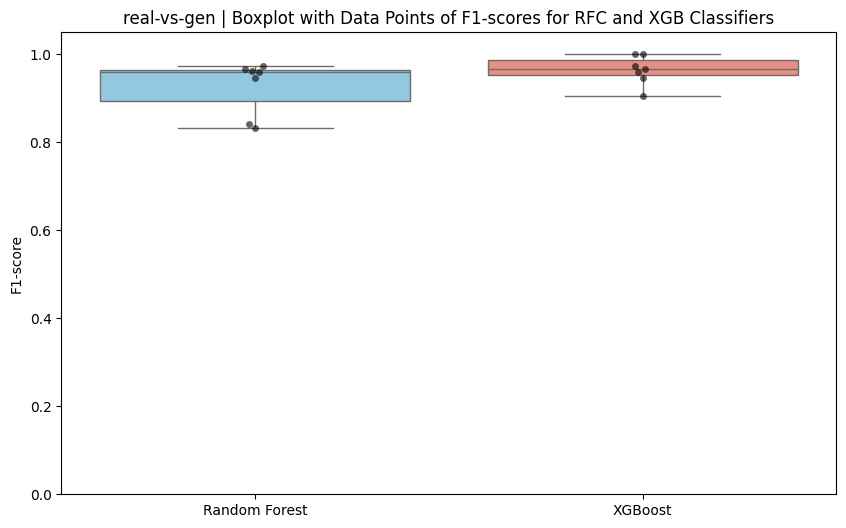

In [104]:
# Combined Boxplot with Swarmplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=metrics_df[['RFC F1-score', 'XGB F1-score']], palette=['skyblue', 'salmon'])
sns.swarmplot(data=metrics_df[['RFC F1-score', 'XGB F1-score']], color='k', alpha=0.6)
plt.title(f'{ads} | Boxplot with Data Points of F1-scores for RFC and XGB Classifiers')
plt.ylabel('F1-score')
plt.xticks([0, 1], ['Random Forest', 'XGBoost'])
plt.ylim(0, 1.05)
plt.show()


In [105]:
def bootstrap_f1(y_true, y_pred, n_bootstraps=1000, random_state=42):
    rng = np.random.RandomState(random_state)
    bootstrapped_scores = []

    for _ in range(n_bootstraps):
        # Resample with replacement
        indices = rng.randint(0, len(y_true), len(y_true))
        if len(np.unique(y_true[indices])) < 2:
            # Skip if only one class is present
            continue
        score = f1_score(y_true[indices], y_pred[indices], average='binary')
        bootstrapped_scores.append(score)

    return np.mean(bootstrapped_scores), np.std(bootstrapped_scores)

# Initialize a list to store bootstrapped metrics
bootstrap_metrics = []

# Iterate over each party
for party in metrics_df.index:
    # Filter the results for the current party
    party_data = results_df[results_df['party_name'] == party]

    # Random Forest
    mean_rfc, std_rfc = bootstrap_f1(party_data['true_class'].values, party_data['predicted_class_rfc'].values)
    # XGBoost
    mean_xgb, std_xgb = bootstrap_f1(party_data['true_class'].values, party_data['predicted_class_xgb'].values)

    # Append the metrics
    bootstrap_metrics.append({
        'Party': party,
        'RFC Mean F1-score': mean_rfc,
        'RFC Std F1-score': std_rfc,
        'XGB Mean F1-score': mean_xgb,
        'XGB Std F1-score': std_xgb
    })

# Create a DataFrame from the bootstrapped metrics
bootstrap_df = pd.DataFrame(bootstrap_metrics).set_index('Party')
bootstrap_df = bootstrap_df.round(3)
bootstrap_df

,RFC Mean F1-score,RFC Std F1-score,XGB Mean F1-score,XGB Std F1-score
Party,,,,
['3POLO'],0.964,0.038,1.000,0.000
['AVD'],0.949,0.052,0.949,0.052
['FDI'],0.843,0.064,0.906,0.048
['FI'],0.973,0.026,0.973,0.026
['LEGA'],0.828,0.069,1.000,0.000
['M5S'],0.965,0.035,0.965,0.035
['PD'],0.961,0.029,0.960,0.030


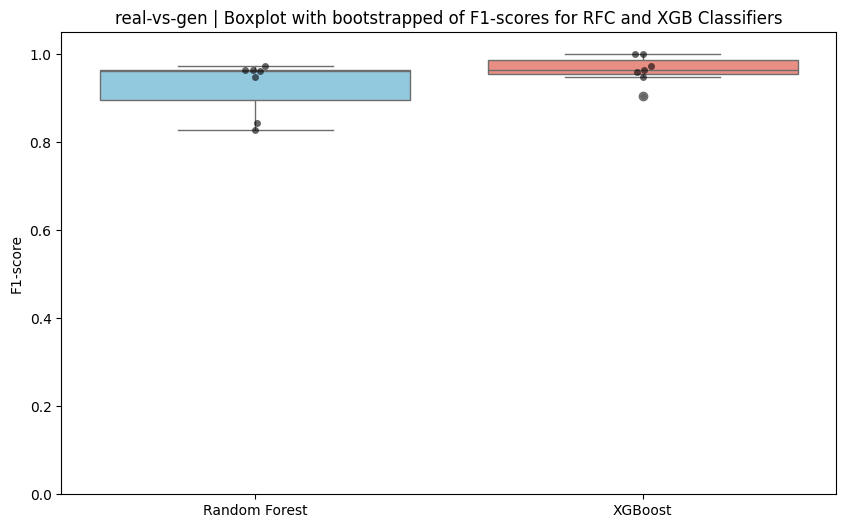

In [106]:
# Combined Boxplot with Swarmplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=bootstrap_df[['RFC Mean F1-score', 'XGB Mean F1-score']], palette=['skyblue', 'salmon'])
sns.swarmplot(data=bootstrap_df[['RFC Mean F1-score', 'XGB Mean F1-score']], color='k', alpha=0.6)
plt.title(f'{ads} | Boxplot with bootstrapped of F1-scores for RFC and XGB Classifiers')
plt.ylabel('F1-score')
plt.xticks([0, 1], ['Random Forest', 'XGBoost'])
plt.ylim(0, 1.05)
plt.show()


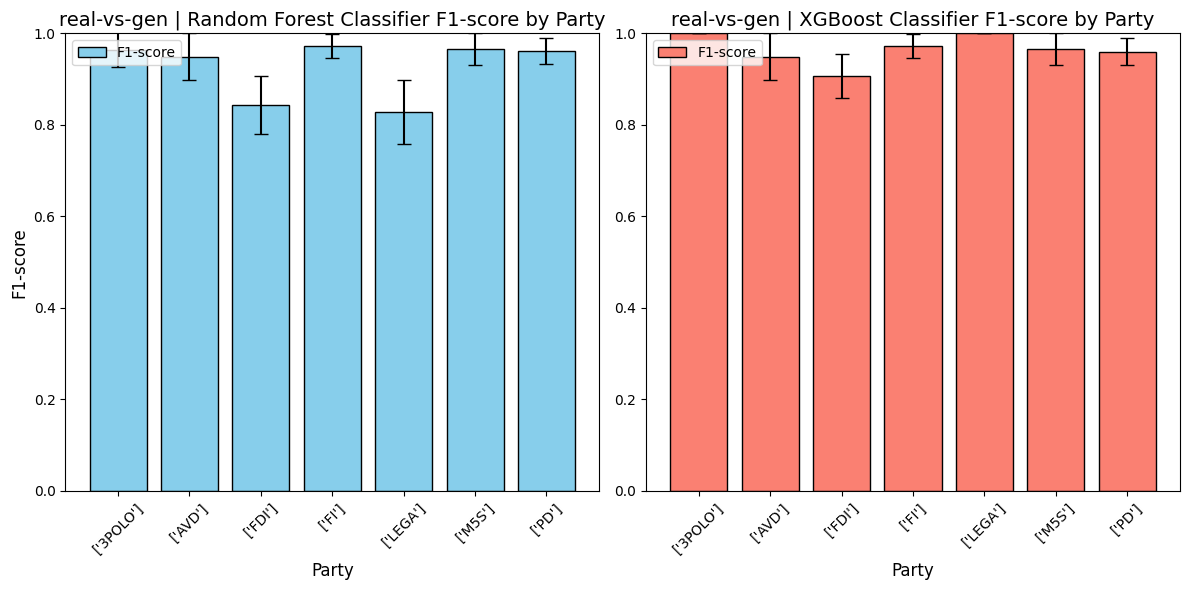

In [107]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot RFC F1-score
axes[0].bar(
    bootstrap_df.index,
    bootstrap_df['RFC Mean F1-score'],
    yerr=bootstrap_df['RFC Std F1-score'],
    capsize=5,
    color='skyblue',
    edgecolor='black'
)
axes[0].set_title(f'{ads} | Random Forest Classifier F1-score by Party', fontsize=14)
axes[0].set_xlabel('Party', fontsize=12)
axes[0].set_ylabel('F1-score', fontsize=12)
axes[0].set_ylim(0, 1)  # Assuming F1-scores range between 0 and 1
axes[0].tick_params(axis='x', rotation=45)

# Plot XGBoost F1-score
axes[1].bar(
    bootstrap_df.index,
    bootstrap_df['XGB Mean F1-score'],
    yerr=bootstrap_df['XGB Std F1-score'],
    capsize=5,
    color='salmon',
    edgecolor='black'
)
axes[1].set_title(f'{ads} | XGBoost Classifier F1-score by Party', fontsize=14)
axes[1].set_xlabel('Party', fontsize=12)
axes[1].set_ylim(0, 1)  # Ensuring the y-axis is consistent
axes[1].tick_params(axis='x', rotation=45)

# Add a legend (optional)
axes[0].legend(['F1-score'], loc='upper left')
axes[1].legend(['F1-score'], loc='upper left')

# Adjust layout for better spacing
plt.tight_layout()

# Display the plots
plt.show()


### Predicted Probabilities

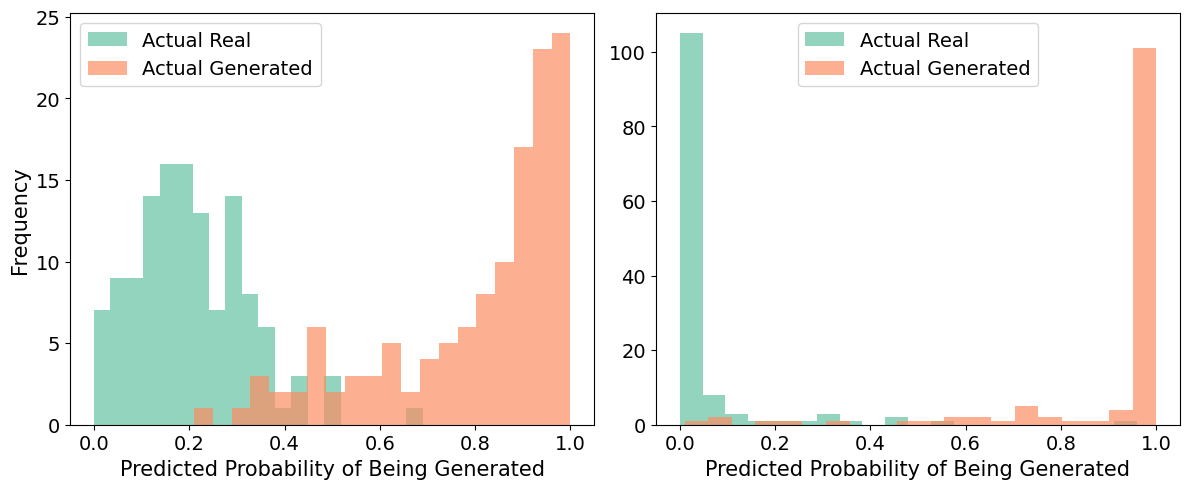

In [108]:
# Get the probability estimates for the positive class ('Generated' assumed to be label 1)
y_score_rfc = rfc_model.predict_proba(X_test)[:, 1]
y_score_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Create a figure with two subplots side by side
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# For Random Forest
ax[0].hist(y_score_rfc[y_test == 0], bins=20, alpha=0.7, label='Actual Real')
ax[0].hist(y_score_rfc[y_test == 1], bins=20, alpha=0.7, label='Actual Generated')
ax[0].set_xlabel('Predicted Probability of Being Generated', fontsize=15)
ax[0].set_ylabel('Frequency', fontsize=15)
ax[0].tick_params(axis='x', labelsize=14)  # Adjust x-axis tick size
ax[0].tick_params(axis='y', labelsize=14)  # Adjust y-axis tick size
# ax[0].set_title(f'{ads} | Random Forest')
ax[0].legend(fontsize=14)

# For XGBoost
ax[1].hist(y_score_xgb[y_test == 0], bins=20, alpha=0.7, label='Actual Real')
ax[1].hist(y_score_xgb[y_test == 1], bins=20, alpha=0.7, label='Actual Generated')
ax[1].set_xlabel('Predicted Probability of Being Generated', fontsize=15)
ax[1].tick_params(axis='x', labelsize=14)  # Adjust x-axis tick size
ax[1].tick_params(axis='y', labelsize=14)  # Adjust y-axis tick size
# ax[1].set_title(f'{ads} | XGBoost')
ax[1].legend(fontsize=14)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

### ROC Curves and AUC Scores

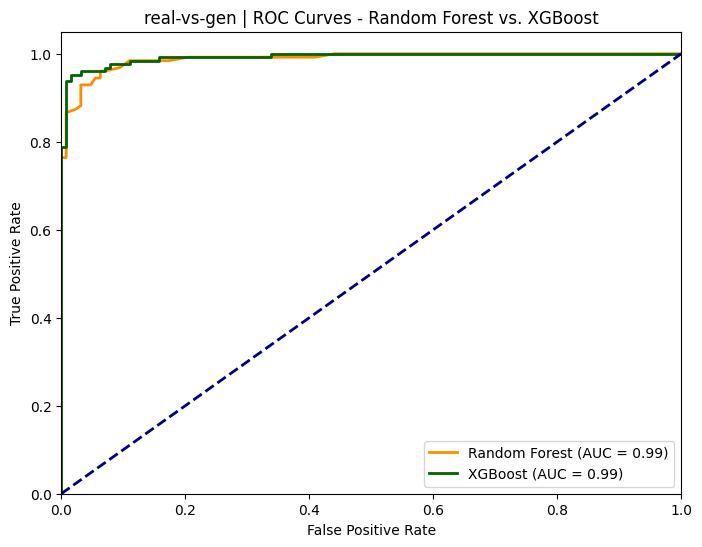

In [109]:
# For Random Forest

# Compute ROC curve and ROC area for Random Forest
fpr_rfc, tpr_rfc, _ = roc_curve(y_test, y_score_rfc)
roc_auc_rfc = auc(fpr_rfc, tpr_rfc)

# For XGBoost

# Compute ROC curve and ROC area for XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_score_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plot both ROC curves on the same plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_rfc, tpr_rfc, color='darkorange', lw=2,
         label='Random Forest (AUC = %0.2f)' % roc_auc_rfc)
plt.plot(fpr_xgb, tpr_xgb, color='darkgreen', lw=2,
         label='XGBoost (AUC = %0.2f)' % roc_auc_xgb)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'{ads} | ROC Curves - Random Forest vs. XGBoost')
plt.legend(loc='lower right')
plt.show()

### Feature Importance

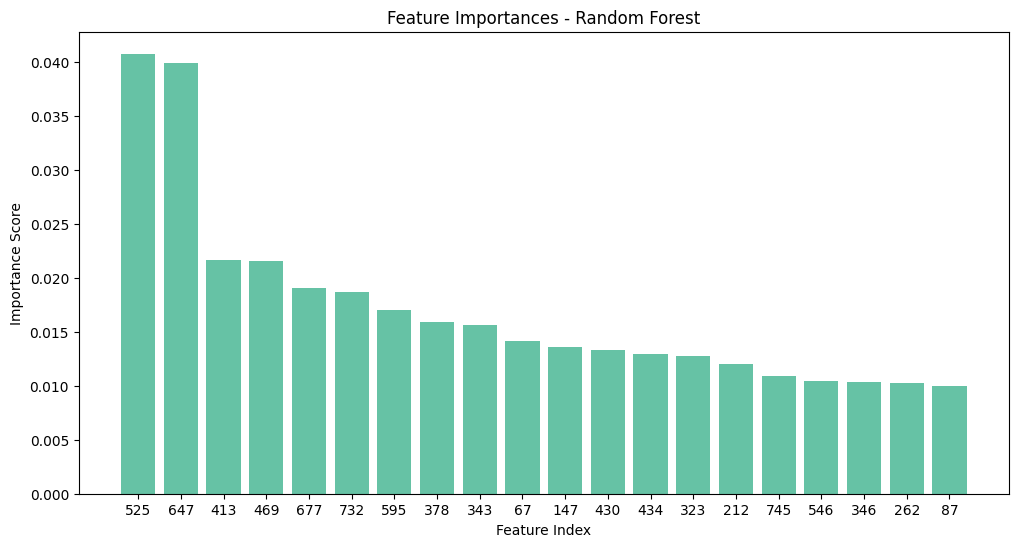

In [110]:
importances = rfc_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the top 20 features
plt.figure(figsize=(12, 6))
plt.title("Feature Importances - Random Forest")
plt.bar(range(20), importances[indices[:20]], align='center')
plt.xticks(range(20), indices[:20])
plt.xlabel('Feature Index')
plt.ylabel('Importance Score')
plt.show()

<Figure size 1200x600 with 0 Axes>

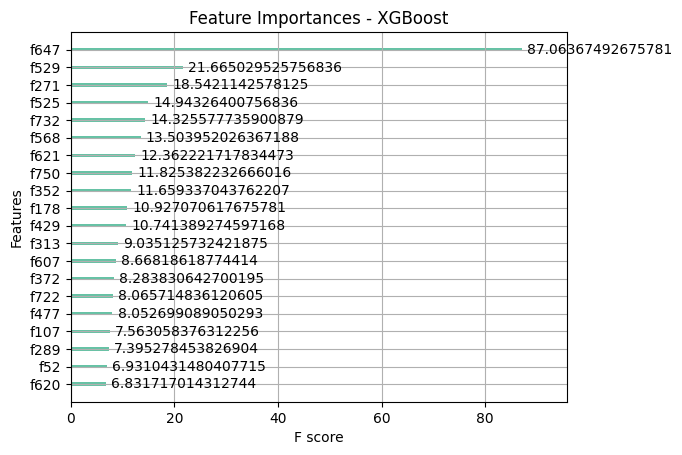

In [111]:
plt.figure(figsize=(12, 6))
plot_importance(xgb_model, max_num_features=20, importance_type='gain')
plt.title("Feature Importances - XGBoost")
plt.show()

## Wrong Predictions

In [112]:
def predict_class(embedding, model, class_names):
    """
    Predicts whether an ad is 'Real' or 'Generated' from a BERT embedding.

    Parameters:
    - embedding (numpy array): The BERT embedding of the ad text.
    - model (sklearn classifier): The trained classifier.
    - class_names (list): List of class names corresponding to label indices.

    Returns:
    - predicted_class (str): The name of the predicted class ('Real' or 'Generated').
    """
    # Ensure the embedding is a 2D array
    embedding = np.array(embedding).reshape(1, -1)

    # Predict the class label
    label_index = model.predict(embedding)[0]

    # Get the class name from the label index
    predicted_class = class_names[label_index]

    return predicted_class

In [113]:
# Initialize a list to collect indices where predictions differ
disagreement_indices = []
error_indices = []

print(f"Errors:\n")
# Loop over all embeddings
for i in range(len(vs_embeddings)):
    # Predict the class using both models
    predicted_class_rfc = predict_class(vs_embeddings[i], rfc_model, class_names)
    predicted_class_xgb = predict_class(vs_embeddings[i], xgb_model, class_names)

    # Get the actual class label
    actual_class = class_names[vs_class_labels[i]]

    if predicted_class_rfc != actual_class and predicted_class_xgb != actual_class:
        print(f"X Error - Actual: {actual_class}, Random Forest: {predicted_class_rfc}, XGBoost: {predicted_class_xgb}")
        print(f"{main_parties[vs_party_labels[i]]} {vs_texts[i]}\n")
        error_indices.append(i)

print(f"Total errors: {len(error_indices)}")

print("\n---\n")

print(f"Disagreements:\n")

# Loop over all embeddings
for i in range(len(vs_embeddings)):
    # Predict the class using both models
    predicted_class_rfc = predict_class(vs_embeddings[i], rfc_model, class_names)
    predicted_class_xgb = predict_class(vs_embeddings[i], xgb_model, class_names)

    # Get the actual class label
    actual_class = class_names[vs_class_labels[i]]

    # Check if the predictions differ between models
    if predicted_class_rfc != predicted_class_xgb:
        print(f"~ Disagreement - Actual: {actual_class}, Random Forest: {predicted_class_rfc}, XGBoost: {predicted_class_xgb}")
        print(f"{main_parties[vs_party_labels[i]]} {vs_texts[i]}\n")
        disagreement_indices.append(i)

print(f"\nTotal disagreements between Random Forest and XGBoost: {len(disagreement_indices)}")

Errors:

X Error - Actual: Real, Random Forest: Generated, XGBoost: Generated
['FDI'] "🔵 Pronti a sostenere le imprese che creano lavoro. Il 25 settembre scegli Fratelli d’Italia.', '🔵 Pronti a sostenere le imprese che creano lavoro. Il 25 settembre scegli Fratelli d’Italia."

X Error - Actual: Generated, Random Forest: Real, XGBoost: Real
['FI'] "Una pillola al giorno leva il medico di torno. Una pillola al giorno del nostro programma dovrebbe levare di torno i signori della sinistra.  La pillola di oggi si chiama #lavoro. Oggi, in Italia, ci sono 5 milioni di disoccupati e 10 milioni di lavoratori poveri.  Noi, quando saremo al governo, introdurremo la #flat tax, ridurremo drasticamente il cuneo fiscale e daremo più soldi ai lavoratori.  Se sei d'accordo, se vuoi che gli stipendi crescano e le aziende abbiano più risorse per investire e creare lavoro, il 25 settembre devi andare a votare e devi votare Forza Italia."

X Error - Actual: Generated, Random Forest: Real, XGBoost: Real
['M

# Test your Ad!

In [114]:
# Load the embedding model
model = SentenceTransformer('nickprock/sentence-bert-base-italian-xxl-uncased')
clear_output()
print("Model loaded")

# Function to predict the class and probability
def predict_ad_text(ad_text, rfc_model, xgb_model, verbose=False):
    """
    Predicts the class of the ad text using the trained models.

    Parameters:
    - ad_text (str): The ad text to predict.
    - rfc_model: Trained Random Forest Classifier.
    - xgb_model: Trained XGBoost Classifier.
    - class_names (list): List of class names corresponding to label indices.

    Returns:
    - None: Prints out the predictions and probabilities.
    """
    # Encode the ad text to get the embedding
    embedding = model.encode(ad_text).reshape(1, -1)

    # Predict with Random Forest
    prob_rfc = rfc_model.predict_proba(embedding)[0]
    pred_rfc = rfc_model.predict(embedding)[0]
    class_name_rfc = class_names[pred_rfc]
    prob_percent_rfc = prob_rfc[pred_rfc] * 100

    # Predict with XGBoost
    prob_xgb = xgb_model.predict_proba(embedding)[0]
    pred_xgb = xgb_model.predict(embedding)[0]
    class_name_xgb = class_names[pred_xgb]
    prob_percent_xgb = prob_xgb[pred_xgb] * 100

    if verbose:
        # Print the results
        print(f"Ad: {ad_text}")
        print("\nRandom Forest Prediction:")
        print(f"{class_name_rfc} - {prob_percent_rfc:.1f}%")
        print("\nXGBoost Prediction:")
        print(f"{class_name_xgb} - {prob_percent_xgb:.1f}%\n")
        return

    return pred_rfc, pred_xgb


Model loaded


In [115]:
# ad_text_input = input("Enter the ad text: ")
ad_text_input = "L'Italia è il Paese che amo. Qui ho le mie radici, le mie speranze, i miei orizzonti. Qui ho imparato, da mio padre e dalla vita, il mio mestiere di imprenditore. Qui ho appreso la passione per la libertà. Ho scelto di scendere in campo e di occuparmi della cosa pubblica perché non voglio vivere in un Paese illiberale, governato da forze immature e da uomini legati a doppio filo a un passato politicamente ed economicamente fallimentare."  # @param {type: "string"}

# Call the prediction function
predict_ad_text(ad_text_input, rfc_model, xgb_model, verbose=True)

Ad: L'Italia è il Paese che amo. Qui ho le mie radici, le mie speranze, i miei orizzonti. Qui ho imparato, da mio padre e dalla vita, il mio mestiere di imprenditore. Qui ho appreso la passione per la libertà. Ho scelto di scendere in campo e di occuparmi della cosa pubblica perché non voglio vivere in un Paese illiberale, governato da forze immature e da uomini legati a doppio filo a un passato politicamente ed economicamente fallimentare.

Random Forest Prediction:
Real - 83.0%

XGBoost Prediction:
Real - 97.4%



# Cross-Validation Implementation

In [116]:
# Define StratifiedKFold
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# # Initialize classifiers with initial hyperparameters
rfc = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42)
xgb = XGBClassifier(n_estimators=200, learning_rate=0.1, eval_metric='logloss', random_state=42)

# Initialize dictionaries to store F1-scores per party
f1_scores_rfc = {party: [] for party in main_parties}
f1_scores_rfc['all_parties'] = []
f1_scores_xgb = {party: [] for party in main_parties}
f1_scores_xgb['all_parties'] = []

In [117]:
# Perform cross-validation
for fold, (train_idx, val_idx) in tqdm(enumerate(skf.split(vs_embeddings, vs_class_labels), 1), total=n_splits):

    # Split data into training and validation for the current fold
    X_train_fold, X_val_fold = vs_embeddings[train_idx], vs_embeddings[val_idx]
    y_train_fold, y_val_fold = vs_class_labels[train_idx], vs_class_labels[val_idx]
    party_val_fold = vs_party_labels[val_idx]

    # Train Random Forest
    rfc.fit(X_train_fold, y_train_fold)
    y_pred_rfc = rfc.predict(X_val_fold)

    # Train XGBoost
    xgb.fit(X_train_fold, y_train_fold)
    y_pred_xgb = xgb.predict(X_val_fold)

    f1_rfc = f1_score(y_val_fold, y_pred_rfc, average='binary')
    f1_xgb = f1_score(y_val_fold, y_pred_xgb, average='binary')
    f1_scores_rfc['all_parties'].append(f1_rfc)
    f1_scores_xgb['all_parties'].append(f1_xgb)

    # Calculate metrics per party
    for party in main_parties:
        # Select samples belonging to the current party
        party_mask = (party_val_fold == main_parties.index(party))
        y_true_party = y_val_fold[party_mask]
        y_pred_rfc_party = y_pred_rfc[party_mask]
        y_pred_xgb_party = y_pred_xgb[party_mask]

        # Avoid division by zero
        if len(y_true_party) == 0:
            continue

        # Calculate Accuracy
        acc_rfc = accuracy_score(y_true_party, y_pred_rfc_party)
        acc_xgb = accuracy_score(y_true_party, y_pred_xgb_party)

        # Calculate F1-score
        f1_rfc = f1_score(y_true_party, y_pred_rfc_party, average='binary', zero_division=0)
        f1_xgb = f1_score(y_true_party, y_pred_xgb_party, average='binary', zero_division=0)

        # Append metrics
        f1_scores_rfc[party].append(f1_rfc)
        f1_scores_xgb[party].append(f1_xgb)


100%|██████████| 5/5 [01:29<00:00, 17.85s/it]


In [118]:
# Compile metrics into a list
metrics_list = []
for party in ['all_parties'] + main_parties:
    metrics_list.append({
        'Party': party,
        'RFC F1-score': np.mean(f1_scores_rfc[party]),
        'RFC Std F1-score': np.std(f1_scores_rfc[party]),
        'XGB F1-score': np.mean(f1_scores_xgb[party]),
        'XGB Std F1-score': np.std(f1_scores_xgb[party])
    })

# Create DataFrame
metrics_df = pd.DataFrame(metrics_list)
metrics_df.set_index('Party', inplace=True)
metrics_df = metrics_df.round(3)

# Display the DataFrame
display(metrics_df)


,RFC F1-score,RFC Std F1-score,XGB F1-score,XGB Std F1-score
Party,,,,
all_parties,0.941,0.023,0.946,0.010
['3POLO'],0.969,0.035,0.974,0.022
['AVD'],0.898,0.077,0.905,0.040
['FDI'],0.863,0.100,0.916,0.055
['FI'],0.967,0.010,0.977,0.015
['LEGA'],0.957,0.014,0.942,0.019
['M5S'],0.974,0.028,0.968,0.031
['PD'],0.941,0.051,0.929,0.024


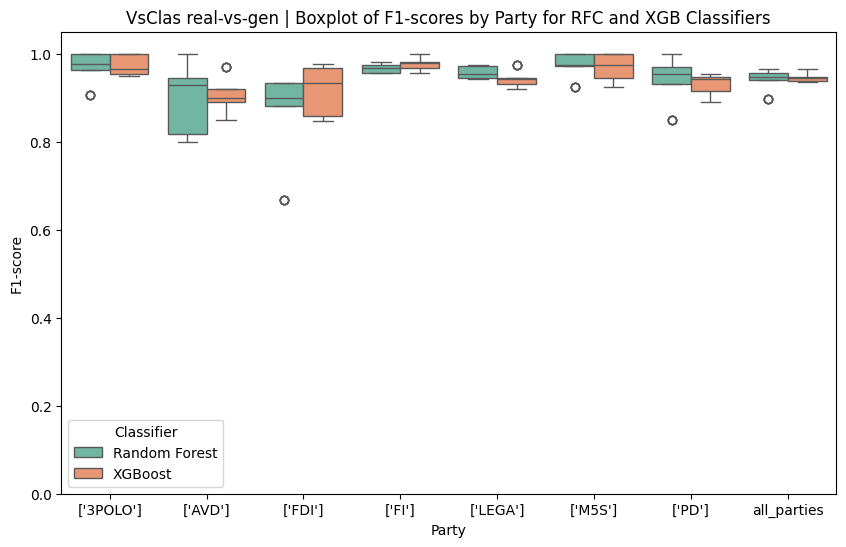

In [119]:
# Prepare data for boxplots
f1_rfc_long = pd.melt(pd.DataFrame(f1_scores_rfc), var_name='Party', value_name='RFC F1-score')
f1_xgb_long = pd.melt(pd.DataFrame(f1_scores_xgb), var_name='Party', value_name='XGB F1-score')

# Merge the two for combined plotting
f1_combined = pd.merge(f1_rfc_long, f1_xgb_long, on='Party')

# Melt the combined DataFrame for seaborn
f1_melted = pd.melt(f1_combined, id_vars=['Party'], value_vars=['RFC F1-score', 'XGB F1-score'],
                    var_name='Classifier', value_name='F1-score')

# Replace classifier names for better readability
f1_melted['Classifier'] = f1_melted['Classifier'].map({
    'RFC F1-score': 'Random Forest',
    'XGB F1-score': 'XGBoost'
})

sns.set_palette("Set2")

# Create Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Party', y='F1-score', hue='Classifier', data=f1_melted)
plt.title(f'VsClas {ads} | Boxplot of F1-scores by Party for RFC and XGB Classifiers')
plt.xlabel('Party')
plt.ylabel('F1-score')
plt.ylim(0, 1.05)
plt.legend(title='Classifier')
plt.show()


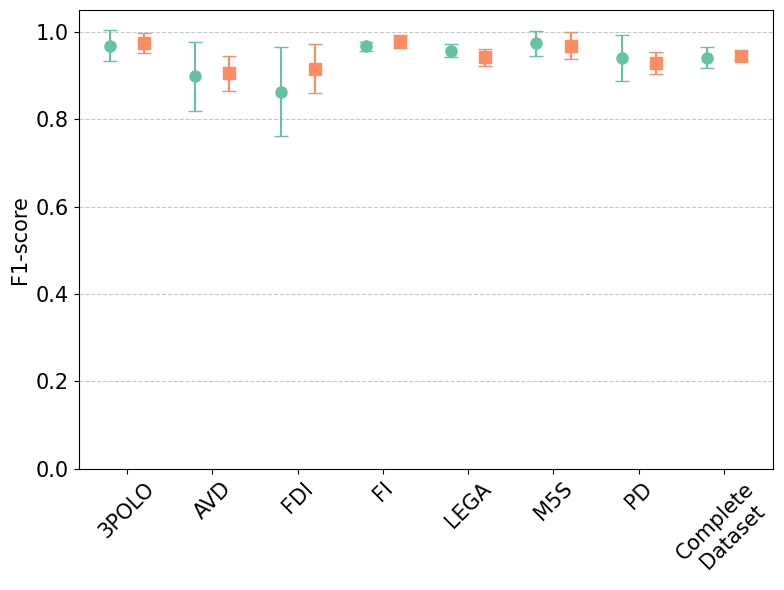

In [120]:
# Set the Seaborn color palette
sns.set_palette("Set2")

# Step 1: Prepare data by melting and merging
f1_rfc_long = pd.melt(
    pd.DataFrame(f1_scores_rfc),
    var_name='Party',
    value_name='RFC F1-score'
)
f1_xgb_long = pd.melt(
    pd.DataFrame(f1_scores_xgb),
    var_name='Party',
    value_name='XGB F1-score'
)

# Merge the two DataFrames on 'Party'
f1_combined = pd.merge(f1_rfc_long, f1_xgb_long, on='Party')

# Step 2: Compute mean and standard deviation for each classifier per Party
f1_stats = f1_combined.groupby('Party').agg(
    RFC_mean=('RFC F1-score', 'mean'),
    RFC_std=('RFC F1-score', 'std'),
    XGB_mean=('XGB F1-score', 'mean'),
    XGB_std=('XGB F1-score', 'std')
).reset_index()

# Optional: If you have NaN std (e.g., only one sample), replace them with 0
f1_stats.fillna(0, inplace=True)

# Step 3: Plotting
# Number of parties
num_parties = len(f1_stats)
indices = np.arange(num_parties)

# Define width for offset to position the error bars side by side
offset = 0.2

plt.figure(figsize=(8, 6))

# Extract colors from the Set2 palette
palette = sns.color_palette("Set2")

# Plot RFC F1-score with left offset
plt.errorbar(
    x=indices - offset,
    y=f1_stats['RFC_mean'],
    yerr=f1_stats['RFC_std'],
    fmt='o',
    ecolor=palette[0],
    capsize=5,
    label='Random Forest',
    color=palette[0],
    markersize=8
)

# Plot XGB F1-score with right offset
plt.errorbar(
    x=indices + offset,
    y=f1_stats['XGB_mean'],
    yerr=f1_stats['XGB_std'],
    fmt='s',
    ecolor=palette[1],
    capsize=5,
    label='XGBoost',
    color=palette[1],
    markersize=8
)

# Set x-ticks to center between the two metrics
plt.xticks(ticks=indices, labels=main_parties_labels, rotation=45, fontsize=15)
plt.yticks(fontsize=15)


# Add titles and labels
# plt.title(f'VsClassifier {ads} | Mean F1-score by Party with Standard Deviation')
# plt.xlabel('Party', fontsize=14)
plt.ylabel('F1-score', fontsize=15)
plt.ylim(0, 1.05)

# Add legend
# plt.legend(title='Classifier', fontsize=12, title_fontsize=12)

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout to prevent clipping of tick-labels
plt.tight_layout()

# Display the plot
plt.show()


# Extra

In [121]:
full = 0

## Extended Tests

In [122]:
if full:
    # Import the CSV file
    extended_fs_gen_text_df = pd.read_csv('mp_generated_ads_party_3.csv')
    # Convert the 'top_ads' column to lists of strings
    extended_fs_gen_text_df['gen_plain_list'] = extended_fs_gen_text_df['gen_plain_list'].apply(eval)

    extended_fs_ordered_text = [text for sublist in extended_fs_gen_text_df['gen_plain_list'] for text in sublist]

    print(len(extended_fs_ordered_text))

    # Lists to collect not selected texts
    not_selected_real_texts = []
    not_selected_generated_texts = []

    # Ensure reproducibility
    np.random.seed(42)

    # Iterate over each party
    for i, party in enumerate(main_parties):
        # Real ads for the party
        party_real_indices = np.where(ra_party_labels == i)[0]
        num_real_ads = len(party_real_indices)

        # Generated ads for the party
        party_generated_indices = np.where(fs_party_labels == i)[0]
        num_generated_ads = len(party_generated_indices)

        # Determine the minimum number of ads between real and generated
        num_ads_to_use = min(num_real_ads, num_generated_ads)

        # Randomly select ads
        selected_real_indices = np.random.choice(party_real_indices, num_ads_to_use, replace=False)
        selected_generated_indices = np.random.choice(party_generated_indices, num_ads_to_use, replace=False)

        # Find not selected indices
        not_selected_real_indices = np.setdiff1d(party_real_indices, selected_real_indices)
        not_selected_generated_indices = np.setdiff1d(party_generated_indices, selected_generated_indices)

        # Collect texts of not selected real ads
        ra_not_selected_texts = [ra_ordered_text[idx] for idx in not_selected_real_indices]
        not_selected_real_texts.extend(ra_not_selected_texts)

        # Collect texts of not selected generated ads
        fs_not_selected_texts = [fs_ordered_text[idx] for idx in not_selected_generated_indices]
        not_selected_generated_texts.extend(fs_not_selected_texts)

    print(f"Total not selected real ads: {len(not_selected_real_texts)}")
    print(f"Total not selected generated ads: {len(not_selected_generated_texts)}")


In [123]:
if full:
    print("not_selected_real_texts - Should be Real 0.9")
    cr_rfc = 0
    cg_rfc = 0
    cr_xgb = 0
    cg_xgb = 0
    for text in not_selected_real_texts:
        rfc, xgb = predict_ad_text(text, rfc_model, xgb_model)
        if rfc == 0: cr_rfc += 1
        else: cg_rfc += 1
        if xgb == 0: cr_xgb += 1
        else: cg_xgb += 1

    print(f"RFC - Real: {cr_rfc}, Generated: {cg_rfc}, r/g: {cr_rfc/(cr_rfc+cg_rfc):.2f}")
    print(f"XGB - Real: {cr_xgb}, Generated: {cg_xgb}, r/g: {cr_xgb/(cr_xgb+cg_xgb):.2f}")

In [124]:
if full:
    print("not_selected_generated_texts - Should be Gen 0.1")
    cr_rfc = 0
    cg_rfc = 0
    cr_xgb = 0
    cg_xgb = 0
    for text in not_selected_generated_texts:
        rfc, xgb = predict_ad_text(text, rfc_model, xgb_model)
        if rfc == 0: cr_rfc += 1
        else: cg_rfc += 1
        if xgb == 0: cr_xgb += 1
        else: cg_xgb += 1

    print(f"RFC - Real: {cr_rfc}, Generated: {cg_rfc}, r/g: {cr_rfc/(cr_rfc+cg_rfc):.2f}")
    print(f"XGB - Real: {cr_xgb}, Generated: {cg_xgb}, r/g: {cr_xgb/(cr_xgb+cg_xgb):.2f}")

In [125]:
if full:
    print("Few-Shots - Should be Gen 0.1")
    cr_rfc = 0
    cg_rfc = 0
    cr_xgb = 0
    cg_xgb = 0
    for text in tqdm(extended_fs_ordered_text):
        rfc, xgb = predict_ad_text(text, rfc_model, xgb_model)
        if rfc == 0: cr_rfc += 1
        else: cg_rfc += 1
        if xgb == 0: cr_xgb += 1
        else: cg_xgb += 1

    print(f"\nRFC - Real: {cr_rfc}, Generated: {cg_rfc}, r/g: {cr_rfc/(cr_rfc+cg_rfc):.2f}")
    print(f"XGB - Real: {cr_xgb}, Generated: {cg_xgb}, r/g: {cr_xgb/(cr_xgb+cg_xgb):.2f}")

In [126]:
if full:
    print("Zero-Shot - Should be Gen 0.1")
    cr_rfc = 0
    cg_rfc = 0
    cr_xgb = 0
    cg_xgb = 0
    for text in tqdm(zs_ordered_text):
        rfc, xgb = predict_ad_text(text, rfc_model, xgb_model)
        if rfc == 0: cr_rfc += 1
        else: cg_rfc += 1
        if xgb == 0: cr_xgb += 1
        else: cg_xgb += 1

    print(f"\nRFC - Real: {cr_rfc}, Generated: {cg_rfc}, r/g: {cr_rfc/(cr_rfc+cg_rfc):.2f}")
    print(f"XGB - Real: {cr_xgb}, Generated: {cg_xgb}, r/g: {cr_xgb/(cr_xgb+cg_xgb):.2f}")